# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

##### ❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

#### 📍 Answer #1

**Question-Document Pairs:** approach trains embedding models using queries/questions paired with relevant documents or passages that answer those questions. The model learns to map questions and their relevant answers to similar vector spaces.

**Inter-Document or Related Sentence Pairs:**  approach trains embedding models using pairs of documents or sentences that are semantically related to each other (not necessarily in a question-answer relationship). Examples include sentences from the same paragraph, adjacent paragraphs, or documents covering the same topic.

**Caveats:**

1. **Query-Document Distribution Gap:**
The model must bridge the lexical and stylistic differences between how people formulate questions versus how answers are written. Questions are typically shorter, we must use interrogative forms, and contain fewer technical terms than answers.
2. **Question Diversity Requirement:**
We need a diverse set of question formulations to build robust models. If our questions are too uniform in style or vocabulary, the model may overfit to those patterns.
3. **Domain Specificity:**
Question-document training is highly sensitive to domain. Models trained on medical Q&A may perform poorly on legal questions.
4. **Negative Sampling Challenges:**
Selecting hard negative examples (documents that seem relevant but aren't actually correct answers) is crucial but difficult to do well.

**Question Types to Include:**
1. Paraphrased Questions: Include multiple ways of asking the same thing
2. Natural Questions: Real user queries rather than artificially constructed ones
3. Questions at Different Expertise Levels: From basic to advanced
4. Multi-hop Questions: Questions requiring information from multiple parts of a document
5. Ambiguous Questions: To teach the model about context importance


## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [2]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

>> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [3]:
!pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/21

In [4]:
!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 18.7 MB/s eta 0:00:00


### Provide OpenAI API Key

In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

Enter Your OpenAI API Key: ··········


## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [6]:
!mkdir data

In [7]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31537    0 31537    0     0   219k      0 --:--:-- --:--:-- --:--:--  218k


In [8]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70704    0 70704    0     0   761k      0 --:--:-- --:--:-- --:--:--  767k


In [9]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)
docs = text_loader.load()

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

> NOTE: You may need to run this cell twice to get it to work.

In [11]:
training_documents = text_splitter.split_documents(docs)

In [12]:
len(training_documents)

102

In [13]:
training_documents[0]

Document(metadata={'source': 'data/2024_llms.html', 'title': 'Things we learned about LLMs in 2024'}, page_content='Things we learned about LLMs in 2024\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSimon Willison’s Weblog\nSubscribe\n\n\n\n\n\n\nThings we learned about LLMs in 2024\n31st December 2024\nA lot has happened in the world of Large Language Models over the course of 2024. Here’s a review of things we figured out about the field in the past twelve months, plus my attempt at identifying key themes and pivotal moments.\nThis is a sequel to my review of 2023.\nIn this article:')

Next, we're going to associate each of our chunks with a unique identifier.

In [14]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [15]:
training_split_documents = training_documents[:len(training_documents) - 24]
val_split_documents = training_documents[len(training_documents) - 24:102-12]
test_split_documents = training_documents[102-12:]

In [16]:
len(training_split_documents)

78

In [17]:
len(val_split_documents)

12

In [18]:
len(test_split_documents)

12

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4.1-mini`

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [19]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [20]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be generated in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [21]:
question_generation_chain = qa_prompt_template | qa_chat_model


**Create Questions**

There's a lot going on in this function a`sync def create_questions(documents, n_questions):` - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with an embedded `metadata` field `id`.

We need:

- **Question Object**: An object with key `id`, which have values `str` questions.
- **Context Object:** An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

**question_object:**
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

** context_object:**
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [22]:
import tqdm
import asyncio

"""
Sample Usage of TQDM:

for i in tqdm.tqdm(range(10)):
  time.sleep(1)
"""
async def process_document(document, n_questions):
    generated_questions = await question_generation_chain.ainvoke({"context":document.page_content, "n_questions":n_questions})

    doc_questions = {}
    doc_documents = {}

    for question in generated_questions.content.split("\n"):
        question_id = str(uuid.uuid4())
        doc_questions[question_id] = " ".join(question.split(":")[1:]).strip()
        doc_documents[question_id] = [document.metadata["id"]]

    return doc_questions, doc_documents

async def create_questions(documents, n_questions):

    # Create a list of tasks to process the documents
    tasks = [process_document(document, n_questions) for document in documents]

    questions = {}
    relevant_docs = {}

    for task in tqdm.tqdm(asyncio.as_completed(tasks), total=len(documents), desc="Processing Documents and Generating Questions"):
        doc_questions, doc_documents = await task
        questions.update(doc_questions)
        relevant_docs.update(doc_documents)

    return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [23]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Processing Documents and Generating Questions: 100%|██████████| 78/78 [00:09<00:00,  8.62it/s]


We'll use the function to generate training, validation, and test data.

In [24]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Processing Documents and Generating Questions: 100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


In [25]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Processing Documents and Generating Questions: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [26]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [27]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [28]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [30]:
!pip install -qU sentence_transformers datasets pyarrow

In [36]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [37]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [38]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [39]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [40]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [41]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

# 👨🏽‍💻 Activity #2 Solution:

`matryoshka_dimensions = [768, 512, 256, 128, 64]:` This line defines a list of dimensions for the **MatryoshkaLoss**. The MatryoshkaLoss allows the model to be trained at various embedding dimensions, which can be useful for optimizing performance and efficiency.

`inner_train_loss = MultipleNegativesRankingLoss(model):` This line creates an instance of the **MultipleNegativesRankingLoss**, which is a common loss function for training embedding models. It takes the pre-trained embedding model as an argument. This loss function encourages the model to rank relevant documents higher than irrelevant ones for a given query.

`train_loss = MatryoshkaLoss(model, inner_train_loss, matryoshka_dims=matryoshka_dimensions):` This line creates an instance of the **MatryoshkaLoss**, which wraps the `inner_train_loss`. It uses the specified `matryoshka_dimensions` to train the model at different embedding sizes.

Using **Matryoshka Representation** the core idea is that the model is trained so that the first k dimensions already form a high‑quality embedding and each additional block of dimensions refines it (“Russian‑doll” structure). The practical implications of this are that we can truncate the vector to any length you like (128 → 256 → 512 → full) without re‑training, trading latency/storage for accuracy.




Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [42]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [46]:
EPOCHS = 15

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [47]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


> NOTE: You may not see direct improvement during the training cycles - this is absolutely expected. We will verify performance later in the notebook.

In [48]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
16,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
32,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
48,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
50,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
64,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
80,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
96,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
100,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
112,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601
128,No log,No log,0.083333,0.250000,0.416667,0.833333,0.083333,0.083333,0.083333,0.083333,0.083333,0.250000,0.416667,0.833333,0.378630,0.244081,0.258601


In [49]:
from huggingface_hub import notebook_login

notebook_login()

In [50]:
hf_username = "pratikmurali"

In [51]:
import uuid
model.push_to_hub(f"{hf_username}/prat-embd-ft-{uuid.uuid4()}")

ValueError: Invalid metadata in README.md.
- "widget[0].source_sentence" is not allowed to be empty
- "widget[1].source_sentence" is not allowed to be empty
- "widget[2].source_sentence" is not allowed to be empty
- "widget[3].source_sentence" is not allowed to be empty
- "widget[4].source_sentence" is not allowed to be empty

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [52]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [53]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [54]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


In [55]:
te3_results_df = pd.DataFrame(te3_results)

In [56]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(0.44)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [57]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 25/25 [00:00<00:00, 48.96it/s]


In [58]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [59]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.4)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [60]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic_ft")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic_ft and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 25/25 [00:00<00:00, 48.45it/s]


In [61]:
finetune_results_df = pd.DataFrame(finetune_results)

In [62]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(0.4)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [63]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [64]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [65]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [66]:
rag_llm =  ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [67]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [68]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'Based on the provided context, an "agent" in the context of AI refers to systems that can act on your behalf, such as travel agents or digital assistants. However, the term is highly vague and lacks a clear, universally accepted definition. The discussions highlight that many people use the term to describe various types of AI systems, including those that can perform tasks or make decisions, but there is no consensus on what exactly constitutes an "agent." Additionally, the concept of AI agents remains somewhat "coming soon," and skepticism exists regarding their current utility, especially given challenges like AI gullibility and the difficulty in distinguishing truth from fiction.'

In [69]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'According to the provided context, organizations that have produced better-than-GPT-3 class models include Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, and Baidu.'

In [70]:
base_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'The provided context does not specify a particular time of year that is considered the "laziest" for AI.'

In [71]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The provided context does not specify the name Simon or detail the specific models he has run on his phone. Therefore, I do not know what the largest model Simon has run on his phone is.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [72]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [73]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [74]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'Based on the provided context, an "agent" in the context of AI and LLMs is a term that is often used but lacks a clear, universally accepted definition. It generally refers to systems that can act on your behalf or perform tasks independently. However, the term is considered vague and has many possible interpretations, which makes it difficult to specify exactly what an AI agent is. The discussions in the documents suggest that true autonomous agents have not yet fully materialized and that their utility is still uncertain due to issues like gullibility and the difficulty of distinguishing truth from fiction.'

In [75]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Several organizations have produced models that are better than GPT-3, including Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII (Falcon), Microsoft Research, xAI, Replit, and Baidu.'

In [76]:
finetune_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

'Based on the provided context, there is a mention that ChatGPT might get lazy in December because its hidden system prompt includes the current date and its training data shows that people provide less useful answers approaching the holidays. Therefore, the laziest time of the year for AI, as suggested by the context, is December.'

In [77]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'The provided context mentions that Simon runs Mistral 7B on his iPhone. Therefore, the largest model he has run on his phone is the Mistral 7B.'

#### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

#### 📍 Answer #2:

The [finetune_rag_chain](https://) LCEL with the fine-tuned embedding model is obviously better in vibe-checks as the base retriever seems to be giving wrong answers. The finetune_rag_chain LCEL on the other hand has contexts associated with the questions and is tuned to answer questions based on the contexts.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [78]:
!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.9 MB/s eta 0:00:00


In [80]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

**Retrieve Node:** Define a LangGraph Graph Node for the Fine Tuned Retriever

In [81]:
def retrieve(state):
  retrieved_docs = finetune_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

**Retrieve Node (Baseline):** Define Baseline Retriever Node


In [82]:
def retrieve_baseline(state):
  retrieved_docs = base_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

Create a RAG Prompt

In [83]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

LLM To Generate the Responses

In [84]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Create a LangGraph Generate Node

In [85]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

**Build the Graph (Fine Tuned Embedding Model)**

In [86]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Test the Graph

In [87]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [88]:
response["response"]

'LLM agents are useful because they represent a powerful yet complex tool that can perform a variety of tasks when trained with adequate and high-quality data. They are easier to build than initially expected, requiring only a few hundred lines of code, although the necessary powerful training data and computing resources may still pose a barrier to entry for hobbyists. \n\nLLMs offer innovative multi-modal capabilities, allowing interactions with not just text but also images, audio, and video, enhancing their applications in various fields. Their ability to learn and generate responses makes them valuable in domains that require creative problem-solving and information generation. \n\nHowever, using LLMs effectively requires understanding their inherent unreliability and developing skills to navigate their limitations, making user education crucial. The evolution of LLM technology continues to enable new functionalities and applications, emphasizing their potential utility across dif

**Build the Graph (Baseline Embedding)**

In [89]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder_baseline = StateGraph(State).add_sequence([retrieve_baseline, generate])
graph_builder_baseline.add_edge(START, "retrieve_baseline")
graph_baseline = graph_builder_baseline.compile()

In [90]:
response = graph_baseline.invoke({"question" : "How are LLM agents useful?"})

In [91]:
response

{'question': 'How are LLM agents useful?',
 'context': [Document(id='da4fba38-5c0c-4f2f-a15a-6bb441caf191', metadata={'source': 'data/2023_llms.html', 'title': 'Stuff we figured out about AI in 2023'}, page_content='Even the openly licensed ones are still the world’s most convoluted black boxes. We continue to have very little idea what they can do, how exactly they work and how best to control them.\nI’m used to programming where the computer does exactly what I tell it to do. Prompting an LLM is decidedly not that!\nThe worst part is the challenge of evaluating them.\nThere are plenty of benchmarks, but no benchmark is going to tell you if an LLM actually “feels” right when you try it for a given task.'),
  Document(id='15515d03-7ea4-4033-8bea-0a1b4ba36848', metadata={'source': 'data/2024_llms.html', 'title': 'Things we learned about LLMs in 2024'}, page_content='Longer inputs dramatically increase the scope of problems that can be solved with an LLM: you can now throw in an entire b

**Evaluate using RAGAS**

In [92]:

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())


In [93]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [94]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What are the notable features and capabilities...,[Universal access to the best models lasted fo...,"Google's Gemini 1.5 Pro, released in February,...",single_hop_specifc_query_synthesizer
1,What recent advancements have been announced f...,[is $2.50 (12x cheaper than GPT-4) and GPT-4o ...,Amazon pre-announced voice mode for Amazon Nov...,single_hop_specifc_query_synthesizer
2,Wht is Googel Gemeni?,[lot) is live video. ChatGPT voice mode now pr...,Google Gemini have a preview of the feature th...,single_hop_specifc_query_synthesizer
3,What role does AGI play in the development of ...,[it since September 2022. I’m beginning to see...,The context suggests that the most popular ide...,single_hop_specifc_query_synthesizer
4,What are the ethical and legal challenges asso...,[<1-hop>\n\nGullibility is the biggest unsolve...,The ethical and legal challenges associated wi...,multi_hop_abstract_query_synthesizer
5,What are the ethical and legal challenges asso...,[<1-hop>\n\nGullibility is the biggest unsolve...,The ethical and legal challenges associated wi...,multi_hop_abstract_query_synthesizer
6,How do Large Language Models (LLMs) balance th...,[<1-hop>\n\nGullibility is the biggest unsolve...,Large Language Models (LLMs) have become easie...,multi_hop_abstract_query_synthesizer
7,How do the advancements in Large Language Mode...,[<1-hop>\n\nGullibility is the biggest unsolve...,The advancements in Large Language Models (LLM...,multi_hop_abstract_query_synthesizer
8,How does the Claude 3.5 Sonnet compare to othe...,"[<1-hop>\n\nmuch as a README file, then follow...",Claude 3.5 Sonnet is benchmarked alongside oth...,multi_hop_specific_query_synthesizer
9,How does Anthropic's approach to LLM developme...,[<1-hop>\n\nis $2.50 (12x cheaper than GPT-4) ...,"Anthropic's approach to LLM development, as se...",multi_hop_specific_query_synthesizer


Let us first evaluate the LangGraph (fine-tuned) with the fine tuned embedding model based retriever.

In [95]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [96]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the notable features and capabilities...,[Gemini 1.5 Pro also illustrated one of the ke...,[Universal access to the best models lasted fo...,"The Google Gemini 1.5 Pro model, released in F...","Google's Gemini 1.5 Pro, released in February,...",single_hop_specifc_query_synthesizer
1,What recent advancements have been announced f...,[Your browser does not support the audio eleme...,[is $2.50 (12x cheaper than GPT-4) and GPT-4o ...,Amazon Nova has pre-announced a voice mode tha...,Amazon pre-announced voice mode for Amazon Nov...,single_hop_specifc_query_synthesizer
2,Wht is Googel Gemeni?,[Structured and Gradual Learning. In organic d...,[lot) is live video. ChatGPT voice mode now pr...,Google Gemini is a series of language models t...,Google Gemini have a preview of the feature th...,single_hop_specifc_query_synthesizer
3,What role does AGI play in the development of ...,[I think this is because of gullibility.\nCan ...,[it since September 2022. I’m beginning to see...,"According to the context, AGI (Artificial Gene...",The context suggests that the most popular ide...,single_hop_specifc_query_synthesizer
4,What are the ethical and legal challenges asso...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,The ethical and legal challenges associated wi...,The ethical and legal challenges associated wi...,multi_hop_abstract_query_synthesizer
5,What are the ethical and legal challenges asso...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,The ethical and legal challenges associated wi...,The ethical and legal challenges associated wi...,multi_hop_abstract_query_synthesizer
6,How do Large Language Models (LLMs) balance th...,[Here’s the sequel to this post: Things we lea...,[<1-hop>\n\nGullibility is the biggest unsolve...,Large Language Models (LLMs) navigate the chal...,Large Language Models (LLMs) have become easie...,multi_hop_abstract_query_synthesizer
7,How do the advancements in Large Language Mode...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,The advancements in Large Language Models (LLM...,The advancements in Large Language Models (LLM...,multi_hop_abstract_query_synthesizer
8,How does the Claude 3.5 Sonnet compare to othe...,[Synthetic data as a substantial component of ...,"[<1-hop>\n\nmuch as a README file, then follow...",The Claude 3.5 Sonnet compares favorably to ot...,Claude 3.5 Sonnet is benchmarked alongside oth...,multi_hop_specific_query_synthesizer
9,How does Anthropic's approach to LLM developme...,[I think people who complain that LLM improvem...,[<1-hop>\n\nis $2.50 (12x cheaper than GPT-4) ...,Anthropic's approach to LLM development with C...,"Anthropic's approach to LLM development, as se...",multi_hop_specific_query_synthesizer


Next Convert the PD Dataframe above into a RAGAs Evaluation Dataset

In [97]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

Now Select an LLM Judge

In [98]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

Evaluate on Raga Metrics

In [99]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.5988, 'faithfulness': 0.6775, 'factual_correctness': 0.4792, 'answer_relevancy': 0.9528, 'context_entity_recall': 0.3916, 'noise_sensitivity_relevant': 0.1737}

Now Let us evaluate the **Baseline Metrics**

In [100]:
for test_row in dataset:
  response = graph_baseline.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [101]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What are the notable features and capabilities...,[The earliest of those was Google’s Gemini 1.5...,[Universal access to the best models lasted fo...,"Google's Gemini 1.5 Pro model, released in Feb...","Google's Gemini 1.5 Pro, released in February,...",single_hop_specifc_query_synthesizer
1,What recent advancements have been announced f...,"[Prompt injection explained, with video, slide...",[is $2.50 (12x cheaper than GPT-4) and GPT-4o ...,Recent advancements for Amazon Nova in the con...,Amazon pre-announced voice mode for Amazon Nov...,single_hop_specifc_query_synthesizer
2,Wht is Googel Gemeni?,[Colophon\n©\n2002\n2003\n2004\n2005\n2006\n20...,[lot) is live video. ChatGPT voice mode now pr...,The provided context does not contain any info...,Google Gemini have a preview of the feature th...,single_hop_specifc_query_synthesizer
3,What role does AGI play in the development of ...,"[Prompt injection explained, with video, slide...",[it since September 2022. I’m beginning to see...,"According to the context, AGI (Artificial Gene...",The context suggests that the most popular ide...,single_hop_specifc_query_synthesizer
4,What are the ethical and legal challenges asso...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,The ethical and legal challenges associated wi...,The ethical and legal challenges associated wi...,multi_hop_abstract_query_synthesizer
5,What are the ethical and legal challenges asso...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,The ethical and legal challenges associated wi...,The ethical and legal challenges associated wi...,multi_hop_abstract_query_synthesizer
6,How do Large Language Models (LLMs) balance th...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,Large Language Models (LLMs) face significant ...,Large Language Models (LLMs) have become easie...,multi_hop_abstract_query_synthesizer
7,How do the advancements in Large Language Mode...,[The legal arguments here are complex. I’m not...,[<1-hop>\n\nGullibility is the biggest unsolve...,The advancements in Large Language Models (LLM...,The advancements in Large Language Models (LLM...,multi_hop_abstract_query_synthesizer
8,How does the Claude 3.5 Sonnet compare to othe...,[Synthetic data as a substantial component of ...,"[<1-hop>\n\nmuch as a README file, then follow...",The context does not provide a direct comparis...,Claude 3.5 Sonnet is benchmarked alongside oth...,multi_hop_specific_query_synthesizer
9,How does Anthropic's approach to LLM developme...,[I think people who complain that LLM improvem...,[<1-hop>\n\nis $2.50 (12x cheaper than GPT-4) ...,"Anthropic's approach to LLM development, espec...","Anthropic's approach to LLM development, as se...",multi_hop_specific_query_synthesizer


In [102]:
from ragas import EvaluationDataset

evaluation_dataset_baseline = EvaluationDataset.from_pandas(dataset.to_pandas())

In [104]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config_baseline = RunConfig(timeout=360)

result_baseline = evaluate(
    dataset=evaluation_dataset_baseline,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config_baseline
)
result_baseline

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.5988, 'faithfulness': 0.6775, 'factual_correctness': 0.4792, 'answer_relevancy': 0.9528, 'context_entity_recall': 0.3916, 'noise_sensitivity_relevant': 0.1737}

# Fine Tuned Embedding Model RAGA Metrics

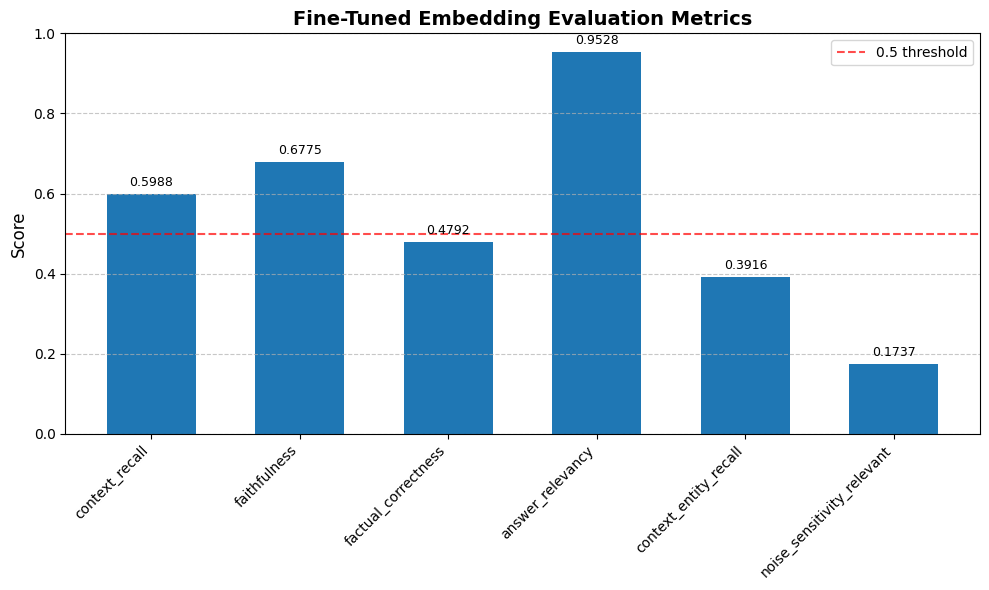

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# The dictionary with metric scores
metrics = {
    'context_recall': 0.5988,
    'faithfulness': 0.6775,
    'factual_correctness': 0.4792,
    'answer_relevancy': 0.9528,
    'context_entity_recall': 0.3916,
    'noise_sensitivity_relevant': 0.1737
    }

# Extract keys and values
categories = list(metrics.keys())
values = list(metrics.values())

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = ax.bar(categories, values, width=0.6)

# Add a horizontal line at y=0.5 for reference
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='0.5 threshold')

# Customize the plot
ax.set_ylim(0, 1.0)  # Set y-axis from 0 to 1
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Fine-Tuned Embedding Evaluation Metrics', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.4f}', ha='center', fontsize=9)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the following line if you want to save the figure
# plt.savefig('metrics_bar_chart.png', dpi=300, bbox_inches='tight')

# Baseline Embedding Model RAGA Metrics

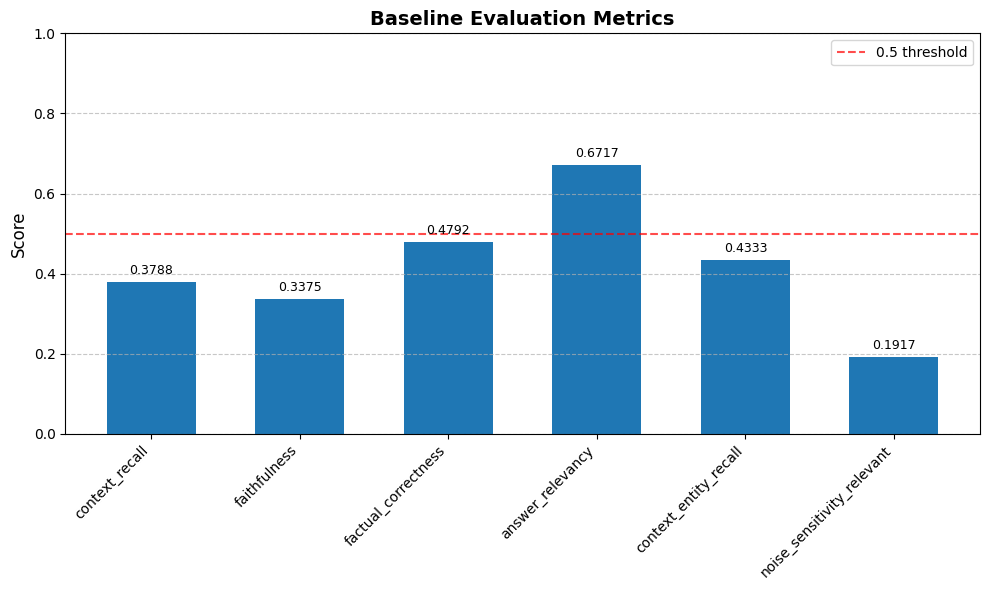

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# The dictionary with metric scores
metrics = {
    'context_recall': 0.3788,
    'faithfulness': 0.3375,
    'factual_correctness': 0.4792,
    'answer_relevancy': 0.6717,
    'context_entity_recall': 0.4333,
    'noise_sensitivity_relevant': 0.1917
    }

# Extract keys and values
categories = list(metrics.keys())
values = list(metrics.values())

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bars = ax.bar(categories, values, width=0.6)

# Add a horizontal line at y=0.5 for reference
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='0.5 threshold')

# Customize the plot
ax.set_ylim(0, 1.0)  # Set y-axis from 0 to 1
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline Evaluation Metrics', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.4f}', ha='center', fontsize=9)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# Uncomment the following line if you want to save the figure
# plt.savefig('metrics_bar_chart.png', dpi=300, bbox_inches='tight')